In [ ]:
  !pip install scikit-fuzzy tensorflow matplotlib numpy scikit-learn

In [13]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [14]:
# =====================
# 1. Domain Definitions
# =====================
temp = np.arange(0, 40.01, 0.01)    # Temperature (°C)
wind = np.arange(0, 14.01, 0.01)    # Wind speed (Beaufort scale)
atm = np.arange(28, 32.01, 0.01)    # Atmospheric pressure (inHg)
rate = np.arange(0, 1.001, 0.001)   # Pressure change rate (inHg/3h)
rain = np.arange(0, 100.01, 0.01)   # Rainfall (mm/h)

# ===========================
# 2. Membership Functions
# ===========================
# Temperature
temp_vl = fuzz.trapmf(temp, [0, 0, 15, 20])  # Very Low
temp_l = fuzz.trimf(temp, [15, 20, 25])      # Low
temp_n = fuzz.trimf(temp, [20, 25, 30])      # Normal
temp_h = fuzz.trimf(temp, [25, 30, 35])      # High
temp_vh = fuzz.trapmf(temp, [30, 35, 40, 40]) # Very High

# Wind Speed
wind_vl = fuzz.trapmf(wind, [0, 0, 2, 4])    # Very Low
wind_l = fuzz.trimf(wind, [2, 4, 6])         # Low
wind_n = fuzz.trimf(wind, [4, 6, 8])         # Normal
wind_h = fuzz.trimf(wind, [6, 8, 10])        # High
wind_vh = fuzz.trapmf(wind, [8, 10, 14, 14]) # Very High

# Atmospheric Pressure
atm_l = fuzz.trapmf(atm, [28, 28, 29.8, 30]) # Low
atm_n = fuzz.trimf(atm, [29.8, 30, 30.2])    # Normal
atm_h = fuzz.trapmf(atm, [30, 30.2, 32, 32]) # High

# Pressure Change Rate
rate_s = fuzz.trapmf(rate, [0, 0, 0.003, 0.005])   # Stable
rate_sc = fuzz.trapmf(rate, [0.003, 0.005, 0.04, 0.18]) # Slowly Changing
rate_rc = fuzz.trapmf(rate, [0.04, 0.18, 1, 1])    # Rapidly Changing

# Rainfall Output
rain_vl = fuzz.trimf(rain, [0, 10, 30])      # Very Low
rain_l = fuzz.trimf(rain, [10, 30, 50])      # Low
rain_n = fuzz.trimf(rain, [30, 50, 70])      # Normal
rain_h = fuzz.trimf(rain, [50, 70, 90])      # High
rain_vh = fuzz.trimf(rain, [70, 90, 100])    # Very High

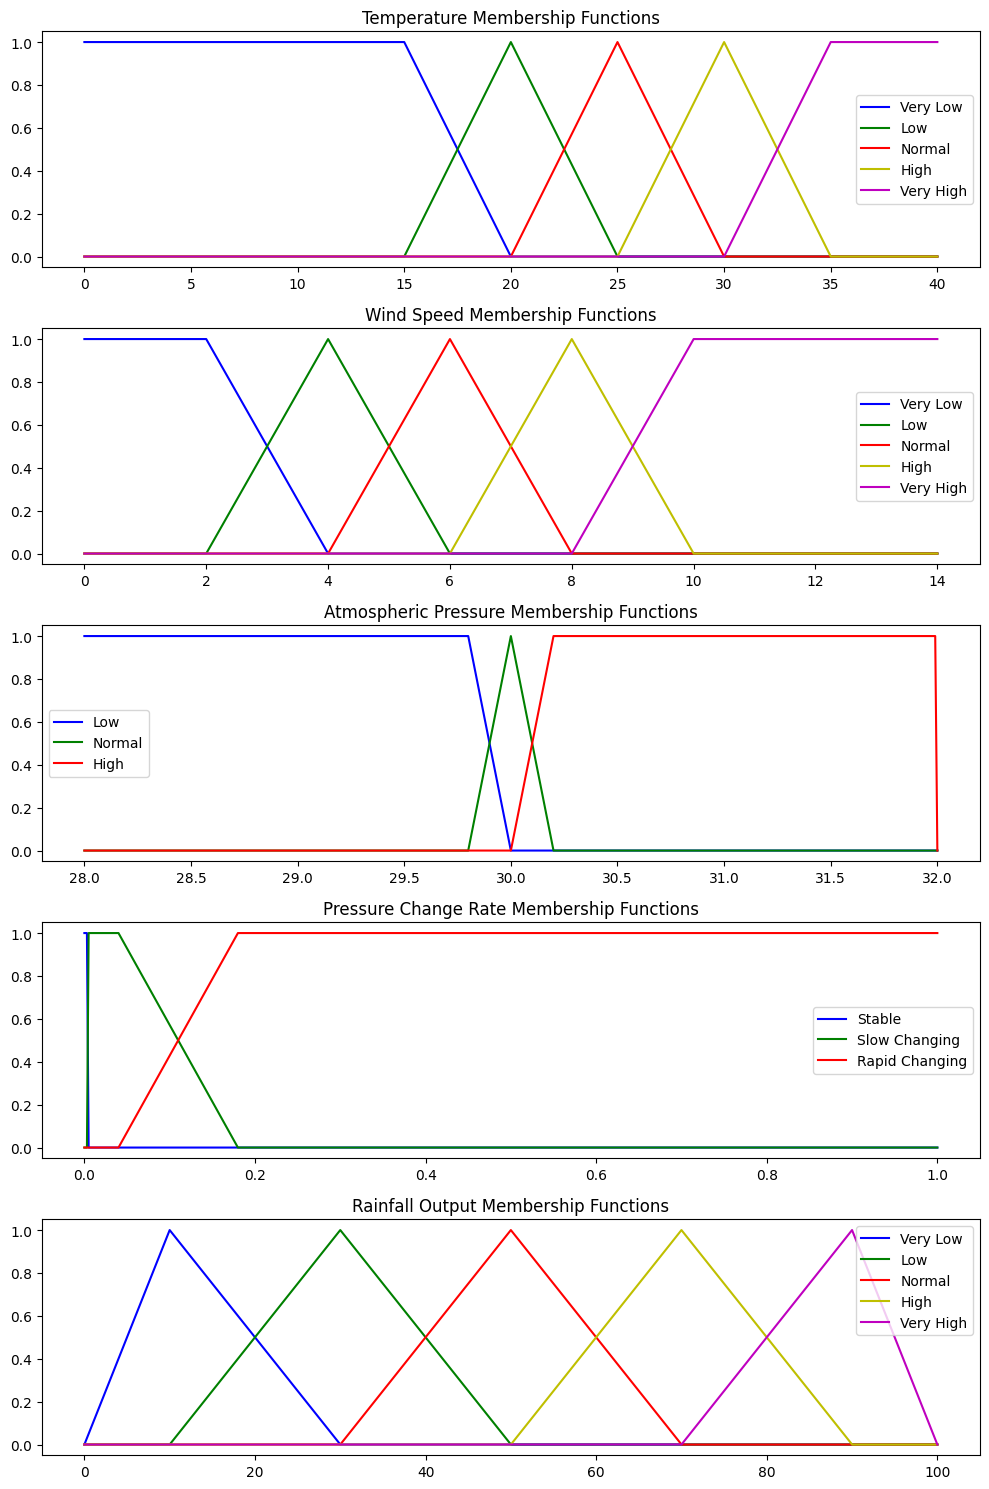

In [15]:
# ===========================
# 3. Visualization Functions
# ===========================
def plot_membership_functions():
    """Visualize all membership functions"""
    fig, axes = plt.subplots(5, 1, figsize=(10, 15))

    # Temperature
    axes[0].plot(temp, temp_vl, 'b', label='Very Low')
    axes[0].plot(temp, temp_l, 'g', label='Low')
    axes[0].plot(temp, temp_n, 'r', label='Normal')
    axes[0].plot(temp, temp_h, 'y', label='High')
    axes[0].plot(temp, temp_vh, 'm', label='Very High')
    axes[0].set_title('Temperature Membership Functions')
    axes[0].legend()

    # Wind
    axes[1].plot(wind, wind_vl, 'b', label='Very Low')
    axes[1].plot(wind, wind_l, 'g', label='Low')
    axes[1].plot(wind, wind_n, 'r', label='Normal')
    axes[1].plot(wind, wind_h, 'y', label='High')
    axes[1].plot(wind, wind_vh, 'm', label='Very High')
    axes[1].set_title('Wind Speed Membership Functions')
    axes[1].legend()

    # Atmospheric Pressure
    axes[2].plot(atm, atm_l, 'b', label='Low')
    axes[2].plot(atm, atm_n, 'g', label='Normal')
    axes[2].plot(atm, atm_h, 'r', label='High')
    axes[2].set_title('Atmospheric Pressure Membership Functions')
    axes[2].legend()

    # Rate of Change
    axes[3].plot(rate, rate_s, 'b', label='Stable')
    axes[3].plot(rate, rate_sc, 'g', label='Slow Changing')
    axes[3].plot(rate, rate_rc, 'r', label='Rapid Changing')
    axes[3].set_title('Pressure Change Rate Membership Functions')
    axes[3].legend()

    # Rainfall
    axes[4].plot(rain, rain_vl, 'b', label='Very Low')
    axes[4].plot(rain, rain_l, 'g', label='Low')
    axes[4].plot(rain, rain_n, 'r', label='Normal')
    axes[4].plot(rain, rain_h, 'y', label='High')
    axes[4].plot(rain, rain_vh, 'm', label='Very High')
    axes[4].set_title('Rainfall Output Membership Functions')
    axes[4].legend()

    plt.tight_layout()
    plt.show()


plot_membership_functions()

In [16]:
# ===========================
# 4. Core Fuzzy Functions
# ===========================
def validate_inputs(input_temp, input_wind, input_atm, input_rate):
    """Ensure inputs are within expected ranges"""
    input_temp = np.clip(input_temp, 0, 40)
    input_wind = np.clip(input_wind, 0, 14)
    input_atm = np.clip(input_atm, 28, 32)
    input_rate = np.clip(input_rate, 0, 1)
    return input_temp, input_wind, input_atm, input_rate

def fuzzification(input_temp, input_wind, input_atm, input_rate):
    """Convert crisp inputs to fuzzy values with validation"""
    # Validate inputs first
    input_temp, input_wind, input_atm, input_rate = validate_inputs(
        input_temp, input_wind, input_atm, input_rate)

    # Temperature membership
    temp_is_vl = fuzz.interp_membership(temp, temp_vl, input_temp)
    temp_is_l = fuzz.interp_membership(temp, temp_l, input_temp)
    temp_is_n = fuzz.interp_membership(temp, temp_n, input_temp)
    temp_is_h = fuzz.interp_membership(temp, temp_h, input_temp)
    temp_is_vh = fuzz.interp_membership(temp, temp_vh, input_temp)

    # Wind speed membership
    wind_is_vl = fuzz.interp_membership(wind, wind_vl, input_wind)
    wind_is_l = fuzz.interp_membership(wind, wind_l, input_wind)
    wind_is_n = fuzz.interp_membership(wind, wind_n, input_wind)
    wind_is_h = fuzz.interp_membership(wind, wind_h, input_wind)
    wind_is_vh = fuzz.interp_membership(wind, wind_vh, input_wind)

    # Atmospheric pressure membership
    atm_is_l = fuzz.interp_membership(atm, atm_l, input_atm)
    atm_is_n = fuzz.interp_membership(atm, atm_n, input_atm)
    atm_is_h = fuzz.interp_membership(atm, atm_h, input_atm)

    # Pressure change rate membership
    rate_is_s = fuzz.interp_membership(rate, rate_s, input_rate)
    rate_is_sc = fuzz.interp_membership(rate, rate_sc, input_rate)
    rate_is_rc = fuzz.interp_membership(rate, rate_rc, input_rate)

    return (
        [temp_is_vl, temp_is_l, temp_is_n, temp_is_h, temp_is_vh],
        [wind_is_vl, wind_is_l, wind_is_n, wind_is_h, wind_is_vh],
        [atm_is_l, atm_is_n, atm_is_h],
        [rate_is_s, rate_is_sc, rate_is_rc]
    )

def inference_engine(temp_arr, wind_arr, atm_arr, rate_arr):
    """Apply fuzzy rules with guaranteed minimum activation"""
    temp_is_vl, temp_is_l, temp_is_n, temp_is_h, temp_is_vh = temp_arr
    wind_is_vl, wind_is_l, wind_is_n, wind_is_h, wind_is_vh = wind_arr
    atm_is_l, atm_is_n, atm_is_h = atm_arr
    rate_is_s, rate_is_sc, rate_is_rc = rate_arr

    # Rule 1: If (temp is very low or low) and (wind is very low or low), rain is very low
    fire_rule1 = min(max(temp_is_vl, temp_is_l), max(wind_is_vl, wind_is_l))
    fire_rule1 = min(min(rate_is_s, atm_is_h), fire_rule1)
    r1_out = np.fmin(fire_rule1, rain_vl)

    # Rule 2: Various combinations for low rain
    fire_rule2 = max(
        min(temp_is_vl, max(wind_is_n, wind_is_h)),
        min(temp_is_l, wind_is_n),
        min(temp_is_n, max(wind_is_vl, wind_is_l)),
        min(temp_is_h, wind_is_vl)
    )
    fire_rule2 = min(max(min(rate_is_s, atm_is_n), min(rate_is_sc, atm_is_h)), fire_rule2)
    r2_out = np.fmin(fire_rule2, rain_l)

    # Rule 3: Various combinations for normal rain
    fire_rule3 = max(
        min(temp_is_vh, wind_is_vl),
        min(max(temp_is_h, temp_is_vh), wind_is_l),
        min(max(temp_is_n, temp_is_h), wind_is_n),
        min(max(temp_is_l, temp_is_n), wind_is_h),
        min(max(temp_is_vl, temp_is_l), wind_is_vh)
    )
    fire_rule3 = min(max(
        min(rate_is_s, atm_is_l),
        min(rate_is_sc, atm_is_n),
        min(rate_is_rc, atm_is_h)
    ), fire_rule3)
    r3_out = np.fmin(fire_rule3, rain_n)

    # Rule 4: Various combinations for high rain
    fire_rule4 = max(
        min(temp_is_vh, wind_is_n),
        min(max(temp_is_h, temp_is_vh), wind_is_h),
        min(max(temp_is_n, temp_is_h), wind_is_vh)
    )
    fire_rule4 = min(max(
        min(rate_is_sc, atm_is_l),
        min(rate_is_rc, atm_is_n)
    ), fire_rule4)
    r4_out = np.fmin(fire_rule4, rain_h)

    # Rule 5: Very high rain conditions
    fire_rule5 = min(temp_is_vh, wind_is_vh)
    fire_rule5 = min(min(rate_is_rc, atm_is_l), fire_rule5)
    r5_out = np.fmin(fire_rule5, rain_vh)

    # Aggregate all rules with minimum activation
    fuzz_out = np.fmax(r1_out, r2_out)
    fuzz_out = np.fmax(fuzz_out, r3_out)
    fuzz_out = np.fmax(fuzz_out, r4_out)
    fuzz_out = np.fmax(fuzz_out, r5_out)

    # Ensure minimum activation
    min_activation = 0.01 * rain_vl
    fuzz_out = np.fmax(fuzz_out, min_activation)

    return fuzz_out

def defuzzification(fuzz_out):
    """Convert fuzzy output to crisp value with error handling"""
    try:
        if np.sum(fuzz_out) == 0 or np.max(fuzz_out) < 0.01:
            return 50.0  # Return midpoint if no rules fired significantly
        return fuzz.defuzz(rain, fuzz_out, "centroid")
    except Exception as e:
        print(f"Defuzzification warning: {str(e)} - Using fallback value")
        return 50.0

In [17]:
# ===========================
# 5. Neural Network Component
# ===========================
class NeuroFuzzyHybrid:
    def __init__(self):
        """Initialize the neural network component"""
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(4,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        self.model.compile(optimizer='adam', loss='mse')

    def train(self, X, y, epochs=100):
        """Train the neural network"""
        history = self.model.fit(X, y, epochs=epochs, validation_split=0.2, verbose=0)
        return history

    def predict(self, X):
        """Predict using the neural network"""
        return self.model.predict(X, verbose=0).flatten()

# ===========================
# 6. Test Data Generation
# ===========================
def generate_test_data(num_samples=1000):
    """Generate synthetic test data with realistic relationships"""
    np.random.seed(42)

    X = np.column_stack([
        np.random.uniform(5, 35, num_samples),      # Temperature (5-35°C)
        np.random.uniform(1, 12, num_samples),     # Wind (1-12 Bft)
        np.random.uniform(29, 31, num_samples),     # Pressure (29-31 inHg)
        np.random.uniform(0.001, 0.5, num_samples) # Rate (0.001-0.5 inHg/3h)
    ])

    # Realistic rainfall calculation
    y = np.zeros(num_samples)
    for i in range(num_samples):
        temp, wind, atm, rate = X[i]

        # Base rain from temperature (more rain at mid-temps)
        temp_effect = 50 * np.sin((temp - 10) * np.pi / 30)

        # Wind amplifies rain effect
        wind_effect = 1 + (wind / 14) * 0.8

        # Lower pressure -> more rain
        pressure_effect = 1 + ((30 - atm) / 2)

        # Faster pressure drop -> more rain
        rate_effect = 1 + rate * 3

        y[i] = temp_effect * wind_effect * pressure_effect * rate_effect
        y[i] = np.clip(y[i], 0, 100)

    return X, y

In [18]:
# ===========================
# 7. Performance Evaluation
# ===========================
def evaluate_performance(y_true, y_pred, system_name):
    """Calculate and display performance metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    accuracy = 100 - (mae / np.mean(y_true)) * 100

    print(f"\n{system_name} Performance:")
    print(f"- MSE: {mse:.2f}")
    print(f"- MAE: {mae:.2f}")
    print(f"- Accuracy: {accuracy:.2f}%")

    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([0, 100], [0, 100], 'r--')
    plt.title(f'{system_name} Prediction vs Actual')
    plt.xlabel('Actual Rainfall (mm/h)')
    plt.ylabel('Predicted Rainfall (mm/h)')
    plt.grid(True)
    plt.show()

    return mse, mae, accuracy

In [19]:
# ===========================
# 8. Test Case Execution
# ===========================
def run_test_cases():
    """Execute predefined test cases with visualization"""
    test_cases = [
        # temp, wind, atm, rate, expected_label
        (5, 1, 31.5, 0.002, "Very Low"),
        (18, 3, 30.5, 0.01, "Low"),
        (25, 5, 30.0, 0.05, "Normal"),
        (32, 9, 29.5, 0.2, "High"),
        (38, 12, 28.5, 0.9, "Very High"),
        (15, 0.5, 30.2, 0.001, "Very Low"),  # Edge case
        (40, 14, 28.0, 1.0, "Very High")    # Edge case
    ]

    print("\nRunning Test Cases:")
    print("="*60)
    for i, (t, w, a, r, expected) in enumerate(test_cases, 1):
        # Fuzzy processing
        temp_arr, wind_arr, atm_arr, rate_arr = fuzzification(t, w, a, r)
        fuzz_out = inference_engine(temp_arr, wind_arr, atm_arr, rate_arr)
        output = defuzzification(fuzz_out)

        # Determine predicted label
        if output <= 20:
            predicted = "Very Low"
        elif output <= 40:
            predicted = "Low"
        elif output <= 60:
            predicted = "Normal"
        elif output <= 80:
            predicted = "High"
        else:
            predicted = "Very High"

        # Display results
        print(f"Test Case {i}:")
        print(f"- Inputs: Temp={t}°C, Wind={w} Bft, Atm={a} inHg, Rate={r} inHg/3h")
        print(f"- Output: {output:.2f} mm/h ({predicted})")
        print(f"- Expected: {expected}")
        print(f"- Match: {'✓' if predicted == expected else '✗'}")
        print("-"*60)

        # Visualize fuzzy output
        plt.figure(figsize=(10, 4))
        plt.plot(rain, fuzz_out, 'b', linewidth=0.5, linestyle='--', label='Aggregated')
        plt.fill_between(rain, fuzz_out, alpha=0.2)
        plt.title(f'Test Case {i}: Fuzzy Output (Defuzzified: {output:.2f})')
        plt.axvline(x=output, color='r', linestyle='--', label=f'Centroid at {output:.2f}')
        plt.legend()
        plt.show()

In [20]:
# ===========================
# 9. Main Execution
# ===========================
def main():
    # 1. Generate and split test data
    X, y = generate_test_data(2000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 2. Initialize hybrid system
    hybrid_system = NeuroFuzzyHybrid()

    # 3. Train neural network
    print("Training neural network component...")
    history = hybrid_system.train(X_train, y_train, epochs=150)

    # 4. Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Neural Network Training')
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # 5. Run fuzzy system on test data
    fuzzy_outputs = np.array([defuzzification(
        inference_engine(*fuzzification(x[0], x[1], x[2], x[3])))
        for x in X_test])

    # 6. Get neural network predictions
    nn_outputs = hybrid_system.predict(X_test)

    # 7. Hybrid predictions (average)
    hybrid_outputs = (fuzzy_outputs + nn_outputs) / 2

    # 8. Evaluate all systems
    fuzzy_metrics = evaluate_performance(y_test, fuzzy_outputs, "Fuzzy System")
    nn_metrics = evaluate_performance(y_test, nn_outputs, "Neural Network")
    hybrid_metrics = evaluate_performance(y_test, hybrid_outputs, "Hybrid System")

    # 9. Run predefined test cases
    run_test_cases()

    # 10. Final comparison
    print("\nFinal Performance Comparison:")
    print(f"{'System':<20} {'MSE':<10} {'MAE':<10} {'Accuracy':<10}")
    print(f"{'Fuzzy':<20} {fuzzy_metrics[0]:<10.2f} {fuzzy_metrics[1]:<10.2f} {fuzzy_metrics[2]:<10.2f}%")
    print(f"{'Neural Network':<20} {nn_metrics[0]:<10.2f} {nn_metrics[1]:<10.2f} {nn_metrics[2]:<10.2f}%")
    print(f"{'Hybrid':<20} {hybrid_metrics[0]:<10.2f} {hybrid_metrics[1]:<10.2f} {hybrid_metrics[2]:<10.2f}%")

    return fuzzy_metrics, nn_metrics, hybrid_metrics

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training neural network component...


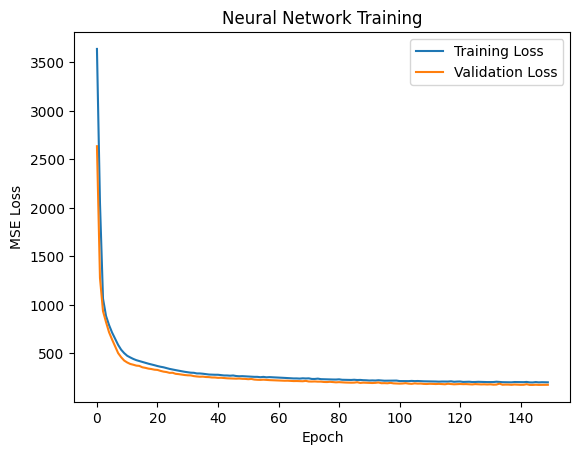


Fuzzy System Performance:
- MSE: 2402.26
- MAE: 39.33
- Accuracy: 32.96%


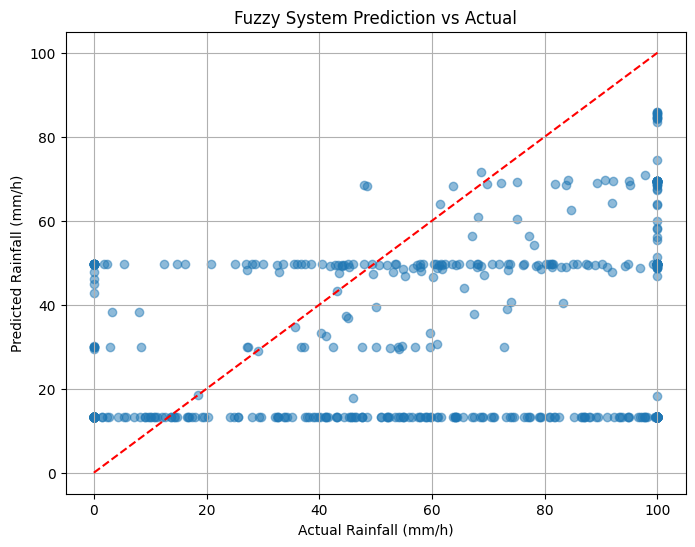


Neural Network Performance:
- MSE: 207.57
- MAE: 10.57
- Accuracy: 81.98%


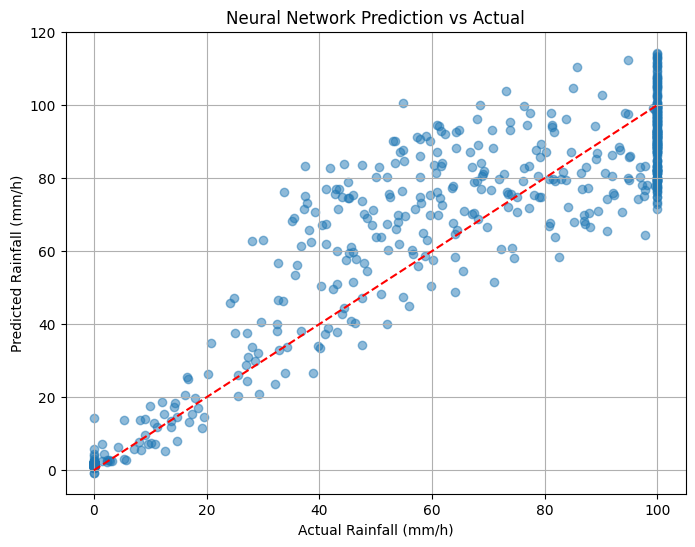


Hybrid System Performance:
- MSE: 729.97
- MAE: 21.23
- Accuracy: 63.80%


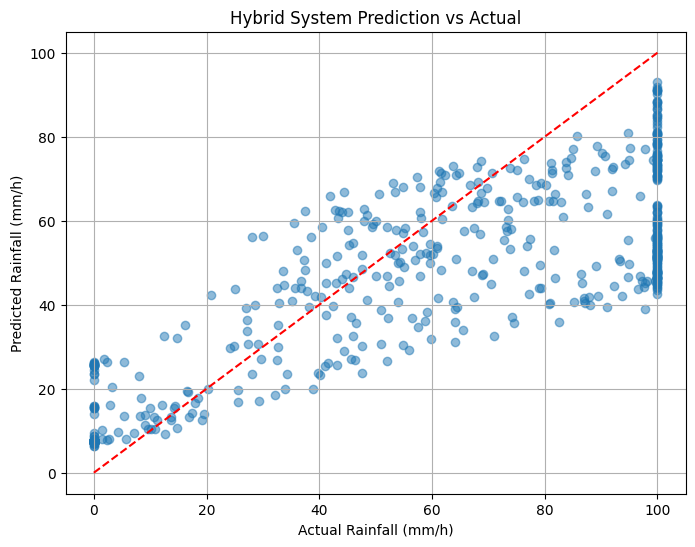


Running Test Cases:
Test Case 1:
- Inputs: Temp=5°C, Wind=1 Bft, Atm=31.5 inHg, Rate=0.002 inHg/3h
- Output: 13.33 mm/h (Very Low)
- Expected: Very Low
- Match: ✓
------------------------------------------------------------


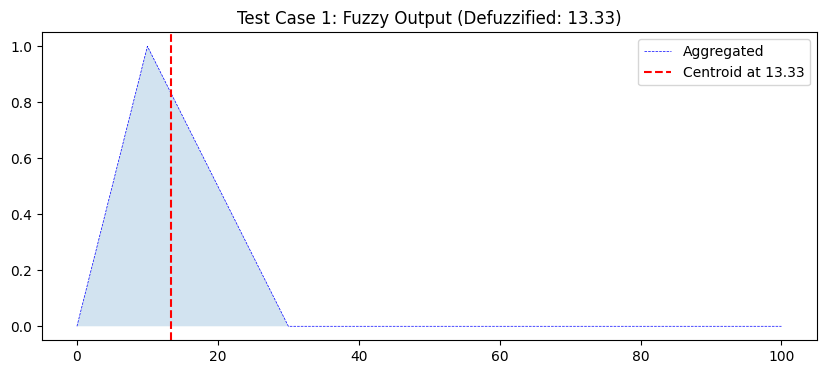

Test Case 2:
- Inputs: Temp=18°C, Wind=3 Bft, Atm=30.5 inHg, Rate=0.01 inHg/3h
- Output: 13.33 mm/h (Very Low)
- Expected: Low
- Match: ✗
------------------------------------------------------------


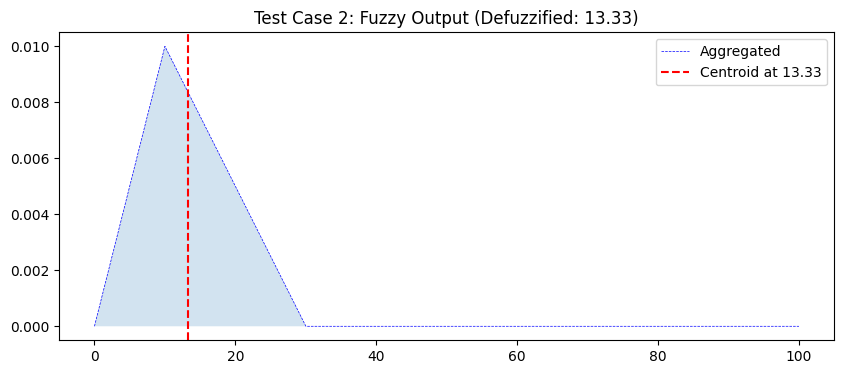

Test Case 3:
- Inputs: Temp=25°C, Wind=5 Bft, Atm=30.0 inHg, Rate=0.05 inHg/3h
- Output: 49.64 mm/h (Normal)
- Expected: Normal
- Match: ✓
------------------------------------------------------------


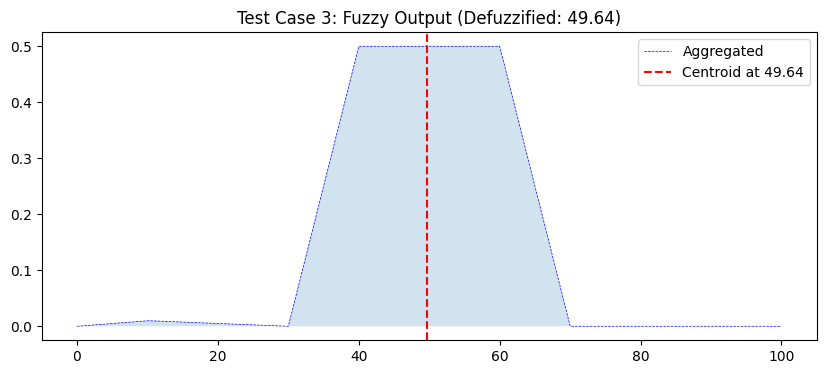

Test Case 4:
- Inputs: Temp=32°C, Wind=9 Bft, Atm=29.5 inHg, Rate=0.2 inHg/3h
- Output: 84.80 mm/h (Very High)
- Expected: High
- Match: ✗
------------------------------------------------------------


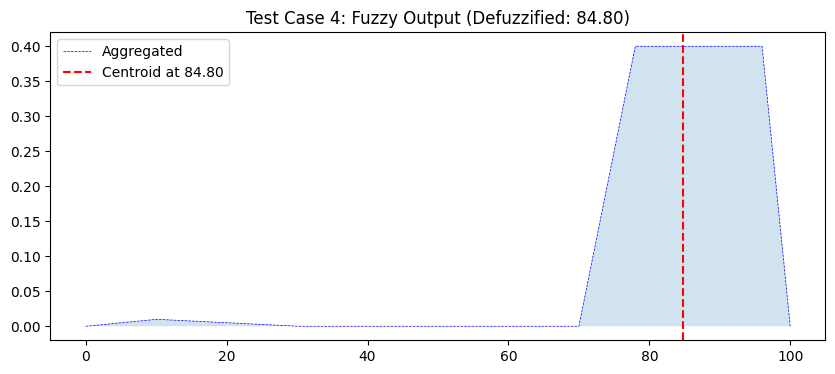

Test Case 5:
- Inputs: Temp=38°C, Wind=12 Bft, Atm=28.5 inHg, Rate=0.9 inHg/3h
- Output: 85.94 mm/h (Very High)
- Expected: Very High
- Match: ✓
------------------------------------------------------------


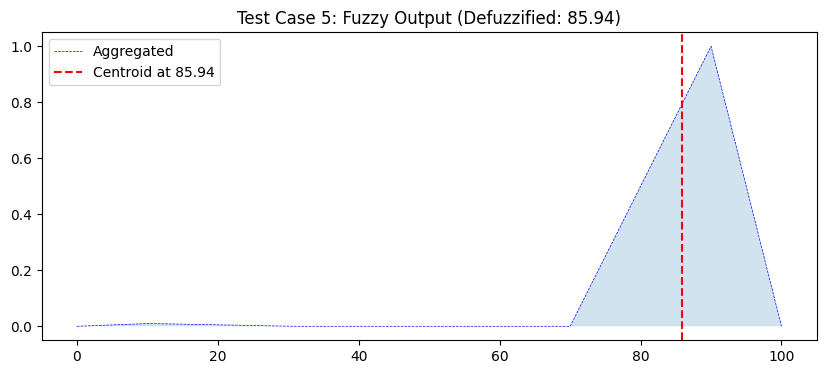

Test Case 6:
- Inputs: Temp=15°C, Wind=0.5 Bft, Atm=30.2 inHg, Rate=0.001 inHg/3h
- Output: 13.33 mm/h (Very Low)
- Expected: Very Low
- Match: ✓
------------------------------------------------------------


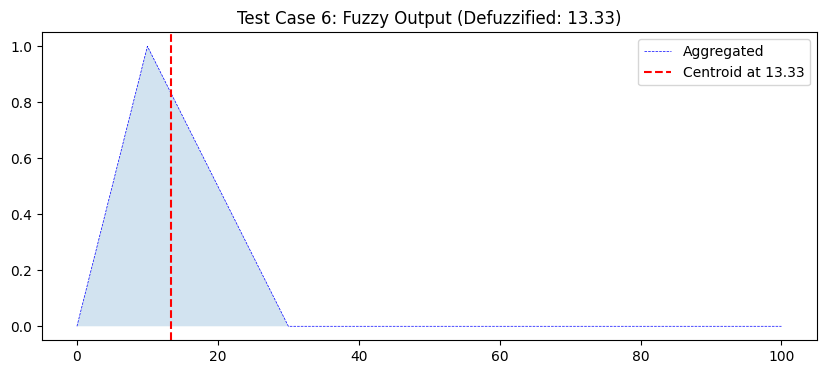

Test Case 7:
- Inputs: Temp=40°C, Wind=14 Bft, Atm=28.0 inHg, Rate=1.0 inHg/3h
- Output: 85.94 mm/h (Very High)
- Expected: Very High
- Match: ✓
------------------------------------------------------------


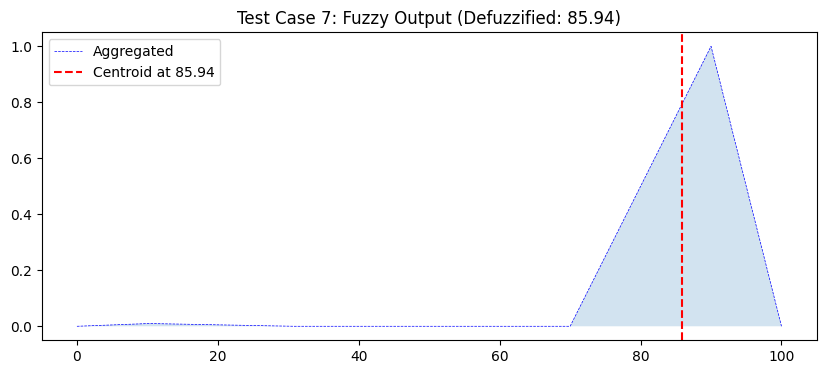


Final Performance Comparison:
System               MSE        MAE        Accuracy  
Fuzzy                2402.26    39.33      32.96     %
Neural Network       207.57     10.57      81.98     %
Hybrid               729.97     21.23      63.80     %


((2402.257955322686, 39.327018422935836, np.float64(32.96367910907746)),
 (207.5707505461571, 10.570759745920677, np.float64(81.98122128742133)),
 (729.9738970468813, 21.234019972734576, np.float64(63.80476746576025)))

In [21]:
main()